Converted from the ocean.py C2D flow example [here](https://github.com/oceanprotocol/ocean.py/blob/main/READMEs/c2d-flow.md). Our example uses the Rinkeby test net instead of a local blockchain (using barge and ganache).

### Set envvars

In the work console:
```console
#set private keys of two accounts
export TEST_PRIVATE_KEY1=0x5d75837394b078ce97bc289fa8d75e21000573520bfa7784a9d28ccaae602bf8
export TEST_PRIVATE_KEY2=0xef4b441145c1d0f3b4bc6d61d29f5c6e502359481152f869247c7a4244d45209
```

In [1]:
import _init_paths
from ocean_lib.ocean.ocean import Ocean
from ocean_lib.config import Config

config = Config('config.ini')
ocean = Ocean(config)

print(f"config.network_url = '{config.network_url}'")
print(f"config.block_confirmations = {config.block_confirmations.value}")
print(f"config.metadata_cache_uri = '{config.metadata_cache_uri}'")
print(f"config.provider_url = '{config.provider_url}'")

config.network_url = 'https://rinkeby.infura.io/v3/d163c48816434b0bbb3ac3925d6c6c80'
config.block_confirmations = 0
config.metadata_cache_uri = 'https://aquarius.oceanprotocol.com'
config.provider_url = 'https://provider.rinkeby.oceanprotocol.com'


In [2]:
# Create Alice's wallet
import os
from ocean_lib.web3_internal.wallet import Wallet
alice_wallet = Wallet(ocean.web3, os.getenv('TEST_PRIVATE_KEY1'), transaction_timeout=20, block_confirmations=config.block_confirmations)
print(f"alice_wallet.address = '{alice_wallet.address}'")

alice_wallet.address = '0xA78deb2Fa79463945C247991075E2a0e98Ba7A09'


In [3]:
assert alice_wallet.web3.eth.get_balance(alice_wallet.address) > 0, "need ETH"

If ETH balance is low, you can request some for alice_wallet.address from the Rinkeby faucet [here](https://faucet.rinkeby.io/) (you'll need to make a tweet). 

## 2. Alice publishes data asset

In [4]:
# Publish DATA datatoken, mint tokens
from ocean_lib.web3_internal.currency import to_wei

DATA_datatoken = ocean.create_data_token('DATA1', 'DATA1', alice_wallet, blob=ocean.config.metadata_cache_uri)
DATA_datatoken.mint(alice_wallet.address, to_wei(100), alice_wallet)
print(f"DATA_datatoken.address = '{DATA_datatoken.address}'")

DATA_datatoken.address = '0xF75D8ADFfDCf408Dd690699B46a4D2b13975D11E'


In [5]:
# Specify metadata & service attributes for Branin test dataset.
# It's specified using _local_ DDO metadata format; Aquarius will convert it to remote
# by removing `url` and adding `encryptedFiles` field.
DATA_metadata = {
    "main": {
        "type": "dataset",
        "files": [
      {
        "url": "https://raw.githubusercontent.com/trentmc/branin/main/branin.arff",
        "index": 0,
        "contentType": "text/text"
      }
    ],
    "name": "branin", "author": "Trent", "license": "CC0",
    "dateCreated": "2019-12-28T10:55:11Z"
    }
}
DATA_service_attributes = {
    "main": {
        "name": "DATA_dataAssetAccessServiceAgreement",
        "creator": alice_wallet.address,
        "timeout": 3600 * 24,
        "datePublished": "2019-12-28T10:55:11Z",
        "cost": 1.0, # <don't change, this is obsolete>
        }
    }

# Set up a service provider. We'll use this same provider for ALG
from ocean_lib.data_provider.data_service_provider import DataServiceProvider
provider_url = DataServiceProvider.get_url(ocean.config)
# returns "http://localhost:8030"

# Calc DATA service compute descriptor
from ocean_lib.services.service import Service
from ocean_lib.common.agreements.service_types import ServiceTypes
DATA_compute_service = Service(
    service_endpoint=provider_url,
    service_type=ServiceTypes.CLOUD_COMPUTE,
    attributes=DATA_service_attributes
)

#Publish metadata and service info on-chain
DATA_ddo = ocean.assets.create(
  metadata=DATA_metadata, # {"main" : {"type" : "dataset", ..}, ..}
  publisher_wallet=alice_wallet,
  services=[DATA_compute_service],
  data_token_address=DATA_datatoken.address)
print(f"DATA did = '{DATA_ddo.did}'")

signing message with nonce 2: 0xF75D8ADFfDCf408Dd690699B46a4D2b13975D11E, account=0xA78deb2Fa79463945C247991075E2a0e98Ba7A09
DATA did = 'did:op:F75D8ADFfDCf408Dd690699B46a4D2b13975D11E'


## 3. Alice publishes algorithm

For this step, there are some prerequisites needed. If you want to replace the sample algorithm with an algorithm of your choosing, you will need to do some dependency management.
You can use one of the standard [Ocean algo_dockers images](https://github.com/oceanprotocol/algo_dockers) or publish a custom docker image.
Use the image name and tag in the `container` part of the algorithm metadata.
This docker image needs to have basic support for dependency installation e.g. in the case of Python, OS-level library installations, pip installations etc.
Take a look at the [Ocean tutorials](https://docs.oceanprotocol.com/tutorials/compute-to-data-algorithms/) to learn more about docker image publishing.

In [6]:
# Publish ALG datatoken
ALG_datatoken = ocean.create_data_token('ALG1', 'ALG1', alice_wallet, blob=ocean.config.metadata_cache_uri)
ALG_datatoken.mint(alice_wallet.address, to_wei(100), alice_wallet)
print(f"ALG_datatoken.address = '{ALG_datatoken.address}'")

# Specify metadata and service attributes, for "GPR" algorithm script.
# In same location as Branin test dataset. GPR = Gaussian Process Regression.
ALG_metadata =  {
    "main": {
        "type": "algorithm",
        "algorithm": {
            "language": "python",
            "format": "docker-image",
            "version": "0.1",
            "container": {
              "entrypoint": "python $ALGO",
              "image": "oceanprotocol/algo_dockers",
              "tag": "python-branin"
            }
        },
        "files": [
      {
        "url": "https://raw.githubusercontent.com/trentmc/branin/main/gpr.py",
        "index": 0,
        "contentType": "text/text",
      }
    ],
    "name": "gpr", "author": "Trent", "license": "CC0",
    "dateCreated": "2020-01-28T10:55:11Z"
    }
}
ALG_service_attributes = {
        "main": {
            "name": "ALG_dataAssetAccessServiceAgreement",
            "creator": alice_wallet.address,
            "timeout": 3600 * 24,
            "datePublished": "2020-01-28T10:55:11Z",
            "cost": 1.0, # <don't change, this is obsolete>
        }
    }

# Calc ALG service access descriptor. We use the same service provider as DATA
ALG_access_service = Service(
    service_endpoint=provider_url,
    service_type=ServiceTypes.CLOUD_COMPUTE,
    attributes=ALG_service_attributes
)

# Publish metadata and service info on-chain
ALG_ddo = ocean.assets.create(
  metadata=ALG_metadata, # {"main" : {"type" : "algorithm", ..}, ..}
  publisher_wallet=alice_wallet,
  services=[ALG_access_service],
  data_token_address=ALG_datatoken.address)
print(f"ALG did = '{ALG_ddo.did}'")

ALG_datatoken.address = '0xf60Cdb89bA746aaFb92232B8eb2e7ba9c9f5B8B7'
signing message with nonce 3: 0xf60Cdb89bA746aaFb92232B8eb2e7ba9c9f5B8B7, account=0xA78deb2Fa79463945C247991075E2a0e98Ba7A09
ALG did = 'did:op:f60Cdb89bA746aaFb92232B8eb2e7ba9c9f5B8B7'


Full details: [ALG_ddo](ALG_ddo.md)

Please note that this example features a simple Python algorithm. If you publish an algorithm in another language, make sure you have an appropriate container to run it, including dependencies.
You can find more information about how to do this in the [Ocean tutorials](https://docs.oceanprotocol.com/tutorials/compute-to-data-algorithms/).

## 4. Alice allows the algorithm for C2D for that data asset

If you try to run the following cell immediately after publish, it might fail. This may be because the asset is not yet cached when the code tries to access it from Aquarius. If this is the case, re-run it and it should work.

In [8]:
from ocean_lib.assets import trusted_algorithms
trusted_algorithms.add_publisher_trusted_algorithm(DATA_ddo, ALG_ddo.did, config.metadata_cache_uri)
ocean.assets.update(DATA_ddo, publisher_wallet=alice_wallet)

'0x0b3ae5019b0d5c8e27074820bed7fdd44bc0ac3c1a101599ab18beaa9699846b'

## 5. Bob acquires datatokens for data and algorithm

In [9]:
bob_wallet = Wallet(ocean.web3, os.getenv('TEST_PRIVATE_KEY2'), transaction_timeout=20, block_confirmations=config.block_confirmations)
print(f"bob_wallet.address = '{bob_wallet.address}'")

# Alice shares access for both to Bob, as datatokens. Alternatively, Bob might have bought these in a market.
DATA_datatoken.transfer(bob_wallet.address, to_wei(5), from_wallet=alice_wallet)
ALG_datatoken.transfer(bob_wallet.address, to_wei(5), from_wallet=alice_wallet)

bob_wallet.address = '0xBE5449a6A97aD46c8558A3356267Ee5D2731ab5e'


'0xb7fd48a5e46288f2f1e8216dca77a2ad6afb94640517a761246aaa8b669b584e'

## 6. Bob starts a compute job

Only inputs needed: DATA_did, ALG_did. Everything else can get computed as needed.

In [10]:
DATA_did = DATA_ddo.did  # for convenience
ALG_did = ALG_ddo.did
DATA_DDO = ocean.assets.resolve(DATA_did)  # make sure we operate on the updated and indexed metadata_cache_uri versions
ALG_DDO = ocean.assets.resolve(ALG_did)

compute_service = DATA_DDO.get_service('compute')
algo_service = ALG_DDO.get_service('access')

from ocean_lib.web3_internal.constants import ZERO_ADDRESS
from ocean_lib.models.compute_input import ComputeInput

# order & pay for dataset
dataset_order_requirements = ocean.assets.order(
    DATA_did, bob_wallet.address, service_type=compute_service.type
)

In [11]:
DATA_order_tx_id = ocean.assets.pay_for_service(
        ocean.web3,
        dataset_order_requirements.amount,
        dataset_order_requirements.data_token_address,
        DATA_did,
        compute_service.index,
        ZERO_ADDRESS,
        bob_wallet,
        dataset_order_requirements.computeAddress,
    )

In [12]:
# order & pay for algo
algo_order_requirements = ocean.assets.order(
    ALG_did, bob_wallet.address, service_type=algo_service.type
)
ALG_order_tx_id = ocean.assets.pay_for_service(
        ocean.web3,
        algo_order_requirements.amount,
        algo_order_requirements.data_token_address,
        ALG_did,
        algo_service.index,
        ZERO_ADDRESS,
        bob_wallet,
        algo_order_requirements.computeAddress,
)

In [13]:
compute_inputs = [ComputeInput(DATA_did, DATA_order_tx_id, compute_service.index)]
job_id = ocean.compute.start(
    compute_inputs,
    bob_wallet,
    algorithm_did=ALG_did,
    algorithm_tx_id=ALG_order_tx_id,
    algorithm_data_token=ALG_datatoken.address
)
print(f"Started compute job with id: {job_id}")

Started compute job with id: 61010a36e1414ec08615a5a18478353c


## 7. Bob monitors logs / algorithm output

You can check the job status as many times as needed:

In [15]:
ocean.compute.status(DATA_did, job_id, bob_wallet)

{'ok': True, 'status': 70, 'statusText': 'Job finished'}

This will output the status of the current job.
Here is a list of possible results: [Operator Service Status description](https://github.com/oceanprotocol/operator-service/blob/main/API.md#status-description).

Once you get `{'ok': True, 'status': 70, 'statusText': 'Job finished'}`, Bob can check the result of the job.

In [16]:
result = ocean.compute.result_file(DATA_did, job_id, 0, bob_wallet)  # 0 index, means we retrieve the results from the first dataset index

You can use the result however you like. For the purpose of this example, let's plot it.


In [17]:
import pickle
model = pickle.loads(result)  # the gaussian model result

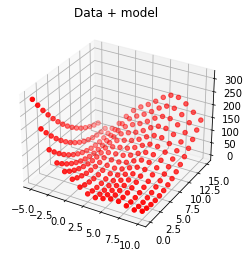

In [18]:
import numpy
from matplotlib import pyplot

X0_vec = numpy.linspace(-5., 10., 15)
X1_vec = numpy.linspace(0., 15., 15)
X0, X1 = numpy.meshgrid(X0_vec, X1_vec)
b, c, t = 0.12918450914398066, 1.5915494309189535, 0.039788735772973836
u = X1 - b*X0**2 + c*X0 - 6
r = 10.*(1. - t) * numpy.cos(X0) + 10
Z = u**2 + r

fig, ax = pyplot.subplots(subplot_kw={"projection": "3d"})
ax.scatter(X0, X1, model, c="r", label="model")
pyplot.title("Data + model")
pyplot.show() # or pyplot.savefig("test.png") to save the plot as a .png file instead